# Preconditioned SGD for high-resolution CryoEM reconstruction

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, config
from tqdm import tqdm
import time
import mrcfile
import optax

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    precon_sgd,
    get_sgd_vol_ops,
    oasis,
    oasis_adaptive,
)
from simplecryoem.utils import rescale_larger_grid, mip_x, mip_y, mip_z
from simplecryoem.fsc import calc_fsc, average_shells, average_shells_2D
from simplecryoem.ctf import eval_ctf

2024-10-14 00:40:38.600256: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = "../../../../Relion_10076/"
star_file = "my_particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

load_data: number of partcles: 76186
load_data: data loaded, time:  46.84 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[43308 36879 60295 45796 33465  5621 40298 10802 19736 63364]


In [5]:
out_dir =  "../../../simplecryoem_output/empiar_10076/"

nx_crop = 192  # 64 #8 #192 # 128 # 64
N = 50000  # 10000 #200 #104000 #80000 # 20000

idx = idx_full[:N]

In [6]:
processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (76186, 320, 320)
pixel_size0.shape = (76186,)
angles0.shape = (76186, 3)
shifts0.shape = (76186, 2)
ctf_params0.shape = (76186, 9)
N0 = 76186
idx provided
N = 50000
Taking FFT of the images:
Batch 1/10  7.40 sec.
Batch 2/10  5.15 sec.
Batch 3/10  5.16 sec.
Batch 4/10  5.16 sec.
Batch 5/10  5.16 sec.
Batch 6/10  5.15 sec.
Batch 7/10  5.16 sec.
Batch 8/10  5.15 sec.
Batch 9/10  5.16 sec.
Batch 10/10  5.16 sec.
FFT done. Time:  62.35 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (50000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [7]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

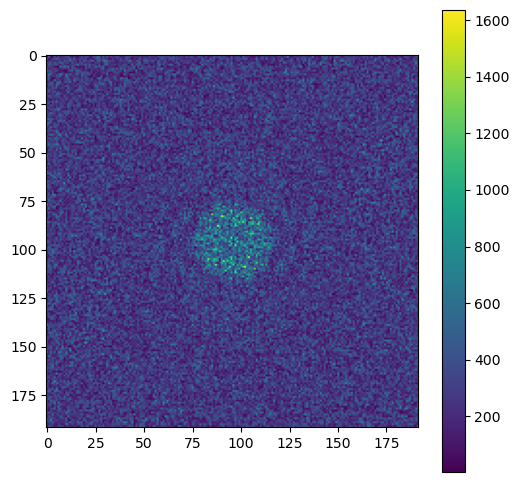

In [8]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [9]:
del imgs0

In [229]:
# Apply mask to images

apply_mask = True

if apply_mask:
    # mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

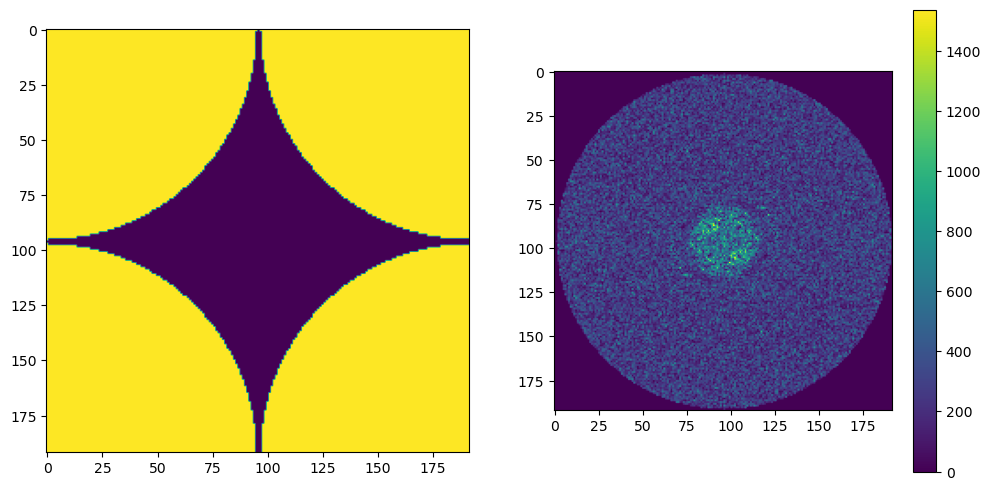

In [230]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop, nx_crop]))))
plt.colorbar()

plt.rcParams["figure.figsize"] = 6, 6

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [231]:
jnp.save(f"{out_dir}/mask.npy", mask)

In [232]:
alpha = 1e-8 
interp_method = "tri" # "tri" or "nn"

# slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)

slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

grad_func, loss_func, hvp_func, loss_px_func = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise
)

### Load a precomputed preconditioner

In [233]:
load_precon = True

if load_precon:
    n_epochs = 100 # 1000
    precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
    D0_loaded = jnp.load(precon_filename)

In [234]:
D0 = D0_loaded

### Or compute a new preconditioner 

Epoch 0


100%|█████████████████████████████████| 50/50 [00:13<00:00,  3.63it/s]


Epoch 1


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 2


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 3


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 4


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 5


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 6


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 7


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 8


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 9


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 10


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 11


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 12


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 13


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 14


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 15


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 16


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 17


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 18


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 19


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 20


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 21


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 22


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 23


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 24


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 25


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 26


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 27


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 28


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 29


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 30


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 31


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 32


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 33


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 34


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 35


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 36


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 37


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 38


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 39


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 40


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 41


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 42


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 43


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 44


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 45


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 46


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 47


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 48


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 49


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 50


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 51


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 52


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 53


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 54


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 55


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 56


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 57


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 58


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 59


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 60


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 61


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 62


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 63


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 64


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 65


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 66


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 67


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 68


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 69


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 70


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 71


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 72


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 73


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 74


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 75


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 76


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 77


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 78


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 79


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 80


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 81


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 82


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 83


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 84


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 85


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 86


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 87


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 88


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 89


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 90


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 91


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 92


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 93


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 94


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 95


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 96


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 97


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 98


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 99


100%|█████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


1.0000000000001084e-08
0.014534637691880316
1453463.7691878742


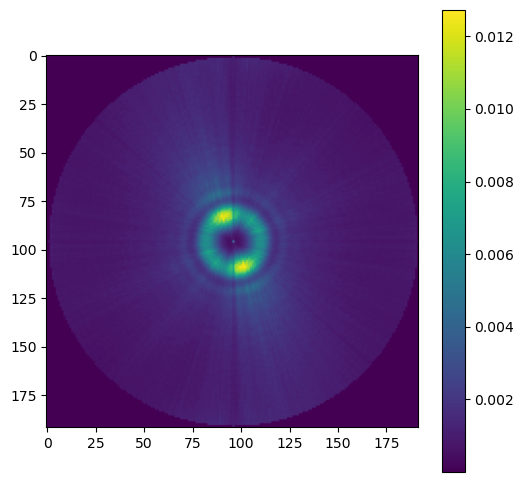

In [15]:
# Exp avg convergence
beta = 0.5
DD0 = jnp.ones([nx, nx, nx])

n_epochs = 100
batch_sz = 1000  # 100
n_batch = N // batch_sz

zD0z = np.zeros([nx, nx, nx])

# zD0z = []

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx, nx, nx], dtype=jnp.complex128)

count = 0
D0err = []
DDerr = []
DD0 = jnp.ones([nx, nx, nx])

for i in range(n_epochs):
    print(f"Epoch {i}")
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N), n_batch)

    for idx in tqdm(idx_batches):
        key, subkey = random.split(key)

        z = random.rademacher(subkey, [nx, nx, nx], dtype=x0.dtype)
        zD0z += z * hvp_func(x0, z, np.array(idx))
        count = count + 1

        Davg = zD0z / count
        DD1 = beta * DD0 + (1 - beta) * Davg
        DD0 = DD1

    # Computing convergence of the Hutchinson's estimator to the true preconditioner
    D0_current = zD0z / count

    if load_precon:
        err_current = D0_loaded - D0_current
        err_current = jnp.sum(jnp.real(jnp.conj(err_current) * err_current))
    
        D0err.append(err_current)
    
        dd_err_current = D0_loaded - DD1
        dd_err_current = jnp.sum(jnp.real(jnp.conj(dd_err_current) * dd_err_current))
    
        DDerr.append(dd_err_current)


zD0z = np.array(zD0z)
D0 = zD0z / (n_epochs * n_batch)

plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0, :, :])))
plt.colorbar()
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)) / jnp.min(jnp.abs(D0)))

In [16]:
# Save the preconditioner
save_precon = True

if save_precon:
    precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
    jnp.save(precon_filename, D0)

In [18]:
jnp.max(jnp.abs(D0 - Davg))

Array(1.73472348e-18, dtype=float64)

In [19]:
print(jnp.max(jnp.abs(D0 - D0_loaded)))
print(jnp.max(jnp.abs(DD1 - D0_loaded)))

NameError: name 'D0_loaded' is not defined

In [ ]:
D0_loaded_norm = jnp.sum(jnp.real(jnp.conj(D0_loaded) * D0_loaded))

In [20]:
startidx = 0
plt.semilogy(
    jnp.sqrt(jnp.array(D0err[startidx:])) / jnp.sqrt(D0_loaded_norm),
    linewidth=2,
    color="r",
)
plt.semilogy(
    jnp.sqrt(jnp.array(DDerr[startidx:])) / jnp.sqrt(D0_loaded_norm),
    linewidth=4,
    linestyle="dotted",
    color="b",
)

# plt.title("$||D-diag(H)||_2 / ||H||_2$", fontsize=22)

plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.legend(["Hutchinson", "Exponential average (proposed)"], fontsize=16)

# plt.savefig(f"Hutch_est_error.eps")

NameError: name 'D0_loaded_norm' is not defined

In [21]:
# When plotting the entries, only show a random subset,
# otherwise the eps image becomes huge.
idxs = random.permutation(key, nx**3)[:100000]

mind = jnp.min(D0_loaded)
maxd = jnp.max(D0_loaded)
xy = jnp.linspace(mind, maxd, 1000)

fig = plt.figure()
ax = plt.gca()

ax.plot(xy, xy, linewidth=3, linestyle="dashed", c="r")
ax.scatter(
    jnp.abs(D0_loaded).reshape(-1)[idxs],
    jnp.abs(DD1).reshape(-1)[idxs],
    s=5,
    c="b",
    marker="o",
)

ax.set_xscale("log")
ax.set_yscale("log")

plt.xlabel("Diagonal(H)", fontsize=16)
plt.ylabel("Estimated diagonal", fontsize=16)

plt.legend(["$x=y$ line", "Diagonal elements"], fontsize=16)
plt.tight_layout()

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.savefig(f"Hutch_est_gt_vs_est.pdf")

NameError: name 'D0_loaded' is not defined

### Compute the Hessian diagonals exactly (valid for NN interpolation)

In [22]:
compute_hess_diag = False

if compute_hess_diag:
    batch_sz = 100
    n_batch = N // batch_sz
    idx_batches = np.array_split(np.arange(N), n_batch)
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)

    D = np.zeros([nx, nx, nx], dtype=np.complex128)
    for idx in idx_batches:
        D += hvp_func(x0, ones, idx)

    D = jnp.array(D / n_batch)

In [23]:
if compute_hess_diag:
    plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0, :, :])))
    plt.colorbar()
    print(jnp.min(jnp.abs(D)))
    print(jnp.max(jnp.abs(D)))
    print(jnp.max(jnp.abs(D)) / jnp.min(jnp.abs(D)))

In [24]:
if compute_hess_diag:
    err1 = jnp.max(jnp.abs(D - D0) / jnp.max(jnp.abs(D)))
    print(f"Error D = {err1}")

#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

In [25]:
if interp_method == "nn":
    ei = jnp.zeros([nx, nx, nx], dtype=jnp.complex128)
    ei = ei.at[0, 2, 1].set(1)
    hvp = hvp_func(x0, ei, np.array([23, 1, 0, 6]))
    plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0, :, :])))
    plt.colorbar()

    print("Checking")
    assert jnp.abs(hvp[0, 2, 1] - jnp.sum(hvp)) == 0

In [26]:
if interp_method == "nn":
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)
    hvp_diag = hvp_func(x0, ones, np.array([23, 1, 0, 6]))  # , 2345, 10000]))
    plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :])))
    plt.colorbar()
    print("Checking")
    assert jnp.abs(hvp[0, 2, 1] - hvp_diag[0, 2, 1]) == 0

### Some plots for the slides/writeup

In [27]:
how_many = 5
if interp_method == "nn":
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)
    hvp_diag = hvp_func(x0, ones, np.random.randint(N, size=how_many))

In [28]:
savefig = False

In [29]:
if interp_method == "nn":
    plt.rcParams["figure.figsize"] = 6, 6

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :])))
    # plt.title("Diagonal of $H$ for $N=5$", fontsize=22)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if savefig:
        plt.savefig(
            f"preconditioner_{interp_method}_N{how_many}.eps", bbox_inches="tight"
        )

In [30]:
if interp_method == "nn":
    plt.rcParams["figure.figsize"] = 6, 6

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(jnp.fft.fftshift(jnp.abs(D[0, :, :])))
    # plt.title("Diagonal of $H$ for $N=5$", fontsize=22)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if savefig:
        plt.savefig(f"preconditioner_{interp_method}_N{N}.eps", bbox_inches="tight")

In [31]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_lbfgs[0])))
plt.clim([0, 4000])
plt.colorbar()
# plt.colorbar()

NameError: name 'v_lbfgs' is not defined

In [32]:
v_lbfgs_slice = jnp.fft.fftshift(jnp.abs(v_lbfgs[0]))
hvp_diag_slice = jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :]))

NameError: name 'v_lbfgs' is not defined

In [33]:
plt.imshow(v_lbfgs_slice)
plt.colorbar()
plt.clim([0, 4000])
plt.title("$v$", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
if savefig:
    plt.savefig("v_fft.eps")

NameError: name 'v_lbfgs_slice' is not defined

In [34]:
plt.imshow(v_lbfgs_slice * hvp_diag_slice)
plt.colorbar()
plt.clim(0, 40)
plt.title("$x_i$", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
if savefig:
    plt.savefig("xi_fft.eps")

NameError: name 'v_lbfgs_slice' is not defined

In [ ]:
savefig = False

### A full dataset loss and grad function, and pixel-wise versions too

In [235]:
def loss_full_func(x, idx_arg):
    idx_batches = np.array_split(idx_arg, 50)

    loss = 0
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        n += 1
    loss = loss / n
    return loss


def grad_full_func(x, idx_arg):
    idx_batches = np.array_split(idx_arg, 20)

    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        grad += grad_func(x, idx)
        n += 1
    grad = grad / n
    return grad


def loss_full_px_func(x, idx_arg):
    idx_batches = np.array_split(idx_arg, 20)

    loss = np.zeros((nx * nx,))
    n = 0
    for idx in idx_batches:
        loss += loss_px_func(x, idx)
        n += 1
    loss = loss / n
    return loss

### Inititial points

In [236]:
# Use a fixed seed and the same size (e.g. 320) every time we generate x01 and x02
# and only then crop to the intended size, to ensure that we always generate the same starting
# points no matter the dimensions.

key = random.PRNGKey(64)
key, subkey = random.split(key)

x0 = random.normal(subkey, [320, 320, 320], dtype=jnp.complex128)

x0 = x0[:nx, :nx, :nx]

key_alg = random.PRNGKey(101)

print(x0[:2, :2, :2])
print(f"PRNGKey = {key_alg}")

[[[-0.37767704-0.82574715j  0.56289944-1.94969685j]
  [-0.7794795 -1.39959255j -0.18751101-0.50461654j]]

 [[-0.28829522+0.87826051j  0.22657018-0.1993285j ]
  [ 0.459454  +0.70868103j -0.38079872+0.73749644j]]]
PRNGKey = [  0 101]


### Common parameters for all runs

In [237]:
N_epochs = 10
batch_size = 1000
iter_display = 1


# Step size for the `sgd` function
eta_sgd = 1

# Initial step size for the `precon_sgd` function
eta_precon_sgd = 10

# Constant that determines the strength of the Armijo condition
c = 0.99

# Preconditioner
if load_precon:
    D0 = D0_loaded

# Weight used in the exponential average when estimating the preconditioner
beta = 0.9 * np.ones(x0.shape)

# Thershold for the preconditioner
# We take this to be the 1/(N points in the largest Fourier shell)
_, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
alpha = 1 / jnp.max(shell_pts)
print(alpha)
D0hat = jnp.maximum(jnp.abs(D0), alpha)

# Directory to save all the iterates for further analysis
iterates_file_root = f"{out_dir}/iterates_{interp_method}/"

5.213981813631434e-06


## Comparison of algorithms

### 1. SGD: no preconditioning

In [ ]:
t0 = time.time()

v_np, loss_np, grad_np, iterates_np, step_sizes_np = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 50/50 [00:42<00:00,  1.18it/s, eta=4.000e+00, grad=1.424e+01, 


  |Grad| = 1.988e+01
  Loss = 1.57064653e+09
  eta = 4.0
  alpha = 1e-10
Epoch 2/10 

 14%|▏| 7/50 [00:04<00:31,  1.38it/s, eta=4.000e+00, grad=1.301e+01, l

In [ ]:
v_np_l, _ = rescale_larger_grid(v_np, x_grid, nx0)
vr_np = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np_l)))

mip_z(vr_np)
plt.colorbar()

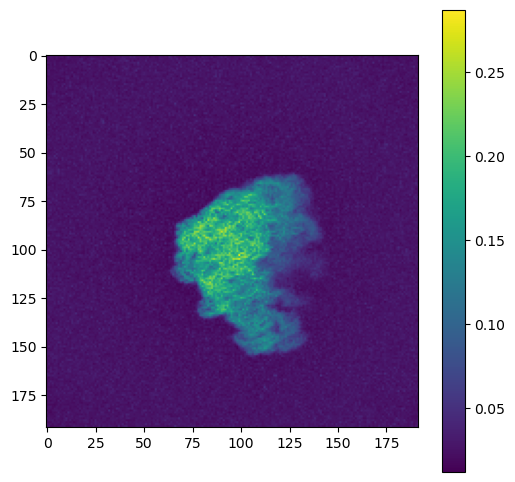

In [44]:
vr_np = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np)))

mip_x(vr_np)
plt.colorbar()

In [ ]:
with mrcfile.new(f"{out_dir}/v_np_sgd_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_np.astype(np.float32))

vr_np_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np)))

with mrcfile.new(f"{out_dir}/v_np_sgd_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_np_nx.astype(np.float32))

In [ ]:
# or load
load_rec = False

if load_rec:
    with mrcfile.open(f"{out_dir}/v_np_nx.mrc") as mrc:
        vr_sgd_loaded = mrc.data

    v_np_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_np_loaded)))

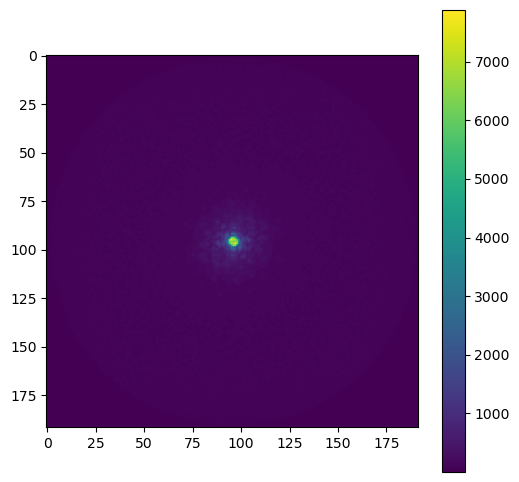

In [52]:
# plt.rcParams["figure.figsize"] = 6, 6

# mip_z(np.fft.fftshift(np.abs(v_rec)))
plt.figure(figsize=(6,6))
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_np)), axis=2))

plt.colorbar()

In [ ]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_np.npy", iterates_np)
    jnp.save(f"{iterates_file_root}/iterates_np_loss.npy", loss_np)
    jnp.save(f"{iterates_file_root}/step_sizes_np.npy", step_sizes_np)

In [66]:
load_iterates = True

if load_iterates:
    iterates_np = np.load(f"{iterates_file_root}/iterates_np.npy")
    loss_np = jnp.load(f"{iterates_file_root}/iterates_np_loss.npy")
    step_sizes_np = jnp.load(f"{iterates_file_root}/step_sizes_np.npy")

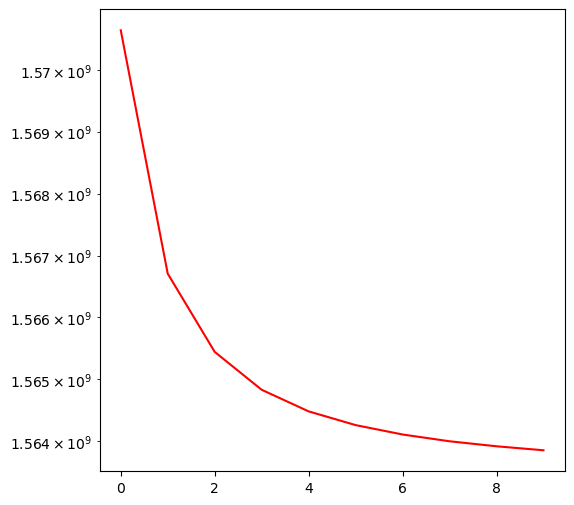

In [28]:
plt.semilogy(loss_np, "r")

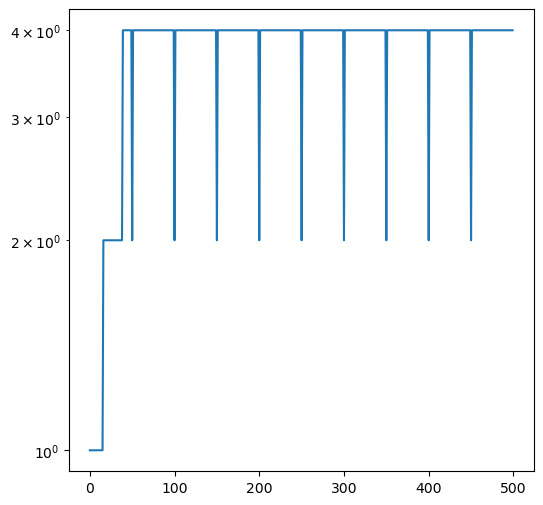

In [29]:
plt.semilogy(step_sizes_np)

### 2a. SGD: precomputed preconditioner (no thresholding) + adaptive line search

In [69]:
t0 = time.time()

(
    v_pp_nothresh,
    loss_pp_nothresh,
    grad_pp_nothresh,
    iterates_pp_nothresh,
    step_sizes_nothresh,
) = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    D0=D0,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
)  

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 100/100 [00:43<00:00,  2.30it/s, eta=7.812e-03, grad=8.744e+00


  |Grad| = 1.481e+01
  Loss = 1.56504645e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 2/10 

100%|█| 100/100 [00:38<00:00,  2.57it/s, eta=7.812e-03, grad=1.098e+01


  |Grad| = 9.470e+00
  Loss = 1.56411516e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 3/10 

100%|█| 100/100 [00:38<00:00,  2.57it/s, eta=7.812e-03, grad=8.295e+00


  |Grad| = 9.245e+00
  Loss = 1.56388278e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 4/10 

100%|█| 100/100 [00:39<00:00,  2.56it/s, eta=7.812e-03, grad=8.718e+00


  |Grad| = 9.400e+00
  Loss = 1.56377936e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 5/10 

100%|█| 100/100 [00:38<00:00,  2.57it/s, eta=7.812e-03, grad=9.282e+00


  |Grad| = 9.381e+00
  Loss = 1.56372686e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 6/10 

100%|█| 100/100 [00:39<00:00,  2.56it/s, eta=7.812e-03, grad=7.981e+00


  |Grad| = 9.259e+00
  Loss = 1.56369674e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 7/10 

100%|█| 100/100 [00:38<00:00,  2.57it/s, eta=7.812e-03, grad=8.576e+00


  |Grad| = 9.509e+00
  Loss = 1.56367814e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 8/10 

100%|█| 100/100 [00:39<00:00,  2.56it/s, eta=7.812e-03, grad=1.040e+01


  |Grad| = 9.366e+00
  Loss = 1.56366755e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 9/10 

100%|█| 100/100 [00:38<00:00,  2.56it/s, eta=7.812e-03, grad=8.877e+00


  |Grad| = 9.405e+00
  Loss = 1.56366099e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 10/10 

100%|█| 100/100 [00:39<00:00,  2.54it/s, eta=7.812e-03, grad=1.079e+01


  |Grad| = 9.234e+00
  Loss = 1.56365571e+09
  eta = 0.0078125
  alpha = 1e-10
Total time:  443.61 seconds


In [70]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_pp_nothresh.npy", iterates_pp_nothresh)
    jnp.save(f"{iterates_file_root}/iterates_pp_nothresh_loss.npy", loss_pp_nothresh)
    jnp.save(f"{iterates_file_root}/step_sizes_pp_nothresh.npy", step_sizes_nothresh)

In [67]:
load_iterates = True

if load_iterates:
    iterates_pp_nothresh = np.load(f"{iterates_file_root}/iterates_pp_nothresh.npy")
    loss_pp_nothresh = jnp.load(f"{iterates_file_root}/iterates_pp_nothresh_loss.npy")
    step_sizes_pp_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_pp_nothresh.npy")

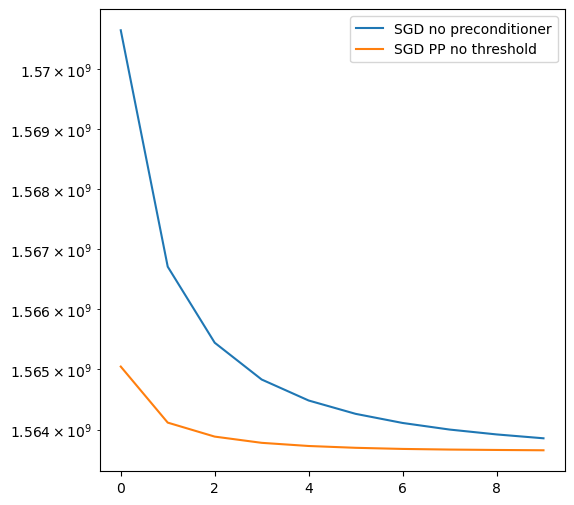

In [31]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp_nothresh, label='SGD PP no threshold')
plt.legend()

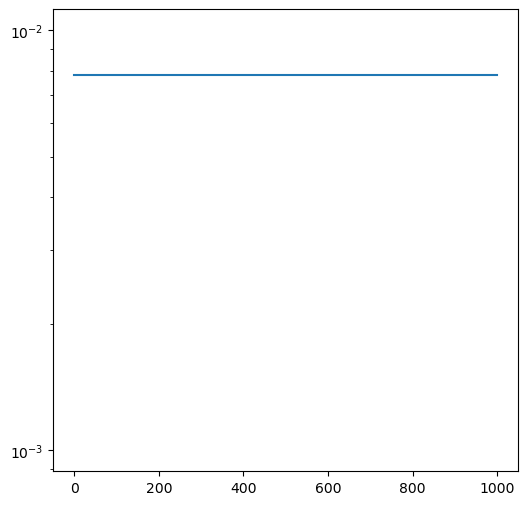

In [32]:
plt.semilogy(step_sizes_pp_nothresh)

### 2b. SGD: precomputed preconditioner (with thresholding) + adaptive line search

In [75]:
print(jnp.min(jnp.abs(1 / D0)))
print(jnp.min(jnp.abs(1 / D0hat)))

print(jnp.max(jnp.abs(1 / D0)))
print(jnp.max(jnp.abs(1 / D0hat)))

68.80116458345871
68.8011645834587
99999999.99998917
191792.0


In [76]:
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))

1.0000000000001084e-08
0.014534637691880316


In [77]:
t0 = time.time()

(
    v_pp,
    loss_pp,
    grad_pp,
    iterates_pp,
    step_sizes_pp,
) = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    D0=D0,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
    alpha=alpha,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 100/100 [00:37<00:00,  2.68it/s, eta=7.812e-03, grad=8.744e+00


  |Grad| = 1.481e+01
  Loss = 1.56504645e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 2/10 

100%|█| 100/100 [00:37<00:00,  2.69it/s, eta=7.812e-03, grad=1.098e+01


  |Grad| = 9.470e+00
  Loss = 1.56411516e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 3/10 

100%|█| 100/100 [00:37<00:00,  2.68it/s, eta=7.812e-03, grad=8.295e+00


  |Grad| = 9.245e+00
  Loss = 1.56388278e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 4/10 

100%|█| 100/100 [00:37<00:00,  2.69it/s, eta=7.812e-03, grad=8.718e+00


  |Grad| = 9.400e+00
  Loss = 1.56377936e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 5/10 

100%|█| 100/100 [00:37<00:00,  2.69it/s, eta=7.812e-03, grad=9.282e+00


  |Grad| = 9.381e+00
  Loss = 1.56372686e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 6/10 

100%|█| 100/100 [00:37<00:00,  2.67it/s, eta=7.812e-03, grad=7.981e+00


  |Grad| = 9.259e+00
  Loss = 1.56369674e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 7/10 

100%|█| 100/100 [00:37<00:00,  2.67it/s, eta=7.812e-03, grad=8.576e+00


  |Grad| = 9.509e+00
  Loss = 1.56367814e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 8/10 

100%|█| 100/100 [00:37<00:00,  2.67it/s, eta=7.812e-03, grad=1.040e+01


  |Grad| = 9.366e+00
  Loss = 1.56366755e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 9/10 

100%|█| 100/100 [00:37<00:00,  2.67it/s, eta=7.812e-03, grad=8.877e+00


  |Grad| = 9.405e+00
  Loss = 1.56366099e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 10/10 

100%|█| 100/100 [00:37<00:00,  2.68it/s, eta=7.812e-03, grad=1.079e+01


  |Grad| = 9.234e+00
  Loss = 1.56365571e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Total time:  422.87 seconds


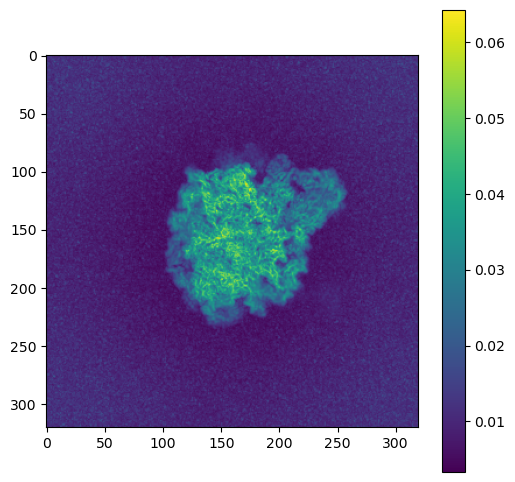

In [78]:
v_pp_l, _ = rescale_larger_grid(v_pp, x_grid, nx0)
vr_pp = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_pp_l)))

mip_z(vr_pp)
plt.colorbar()

In [80]:
with mrcfile.new(f"{out_dir}/v_rec_pp_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_pp.astype(np.float32))
with mrcfile.new(f"{out_dir}/v_pp_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_pp_nx.astype(np.float32))

vr_pp_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_pp)))

In [34]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_pp_nx.mrc") as mrc:
        vr_pp_loaded = mrc.data

    v_pp_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_pp_loaded)))

    # vrerr = jnp.abs(v_pp - v_pp_loaded)
    # print(jnp.max(vrerr) / jnp.max(jnp.abs(v_pp)))
    # print(jnp.mean(vrerr) / jnp.max(jnp.abs(v_pp)))

In [83]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_pp.npy", iterates_pp)
    jnp.save(f"{iterates_file_root}/iterates_pp_loss.npy", loss_pp)
    jnp.save(f"{iterates_file_root}/step_sizes_pp.npy", step_sizes_pp)

In [68]:
load_iterates = True

if load_iterates:
    iterates_pp = np.load(f"{iterates_file_root}/iterates_pp.npy")
    loss_pp = jnp.load(f"{iterates_file_root}/iterates_pp_loss.npy")
    step_sizes_pp = jnp.load(f"{iterates_file_root}/step_sizes_pp.npy")

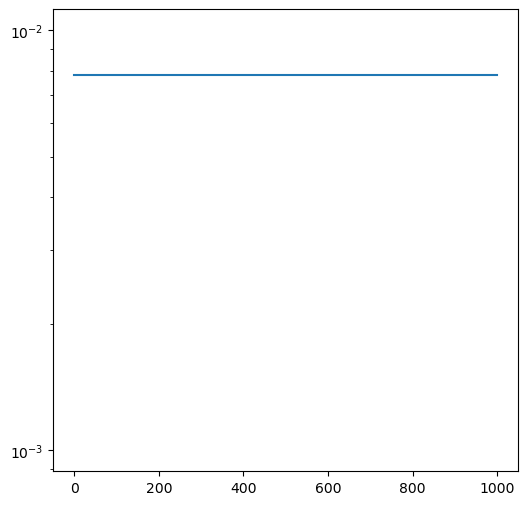

In [36]:
plt.semilogy(step_sizes_pp)

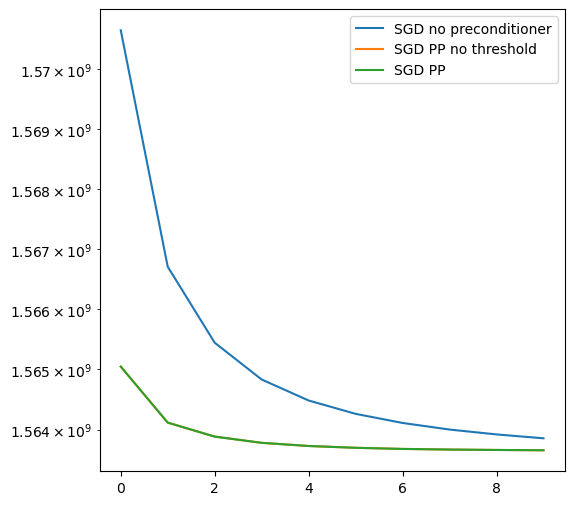

In [40]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp_nothresh, label='SGD PP no threshold')
plt.semilogy(loss_pp, label='SGD PP')

plt.legend()

### 3a. SGD: estimated preconditioner (Algorithm 1)

In [90]:
t0 = time.time()

v_ep, loss_ep, iterates_ep, step_sizes_ep = precon_sgd(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha,
    N_epochs,
    batch_size=batch_size,
    N=N,
    adaptive_step_size=True,
    c=c,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10


100%|█| 100/100 [00:44<00:00,  2.25it/s, eta=6.026e-03, loss=1.565e+09


  Loss =  1.56581496e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 2/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.564e+09


  Loss =  1.56434044e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 3/10


100%|█| 100/100 [00:41<00:00,  2.43it/s, eta=6.026e-03, loss=1.559e+09


  Loss =  1.56399948e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 4/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.563e+09


  Loss =  1.56385367e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 5/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.562e+09


  Loss =  1.56378037e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 6/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.559e+09


  Loss =  1.56373968e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 7/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.561e+09


  Loss =  1.56371240e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 8/10


100%|█| 100/100 [00:41<00:00,  2.43it/s, eta=6.026e-03, loss=1.564e+09


  Loss =  1.56369728e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 9/10


100%|█| 100/100 [00:41<00:00,  2.41it/s, eta=6.026e-03, loss=1.561e+09


  Loss =  1.56368604e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Epoch 10/10


100%|█| 100/100 [00:41<00:00,  2.42it/s, eta=6.026e-03, loss=1.565e+09


  Loss =  1.56368071e+09
  eta = 0.00602580072314699
  alpha= 5.213981813631434e-06
Total time:  465.84 seconds


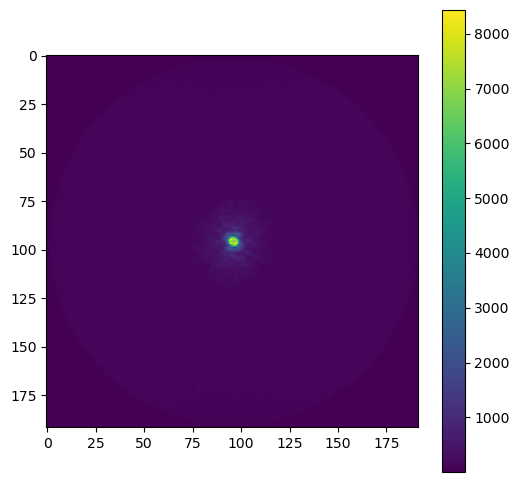

In [91]:
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_ep)), axis=1))
plt.colorbar()

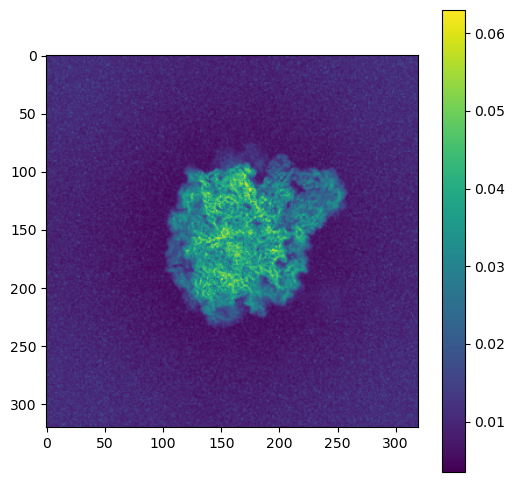

In [92]:
v_ep_l, _ = rescale_larger_grid(v_ep, x_grid, nx0)
vr_ep = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_ep_l)))

mip_z(vr_ep)
plt.colorbar()

In [93]:
with mrcfile.new(f"{out_dir}/v_ep_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_ep.astype(np.float32))

vr_ep_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_ep)))

with mrcfile.new(f"{out_dir}/v_ep_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_ep_nx.astype(np.float32))

In [41]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_ep_nx.mrc") as mrc:
        vr_ep_loaded = mrc.data

    v_ep_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_ep_loaded)))

In [95]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_ep.npy", iterates_ep)
    jnp.save(f"{iterates_file_root}/iterates_ep_loss.npy", loss_ep)
    jnp.save(f"{iterates_file_root}/step_sizes_ep.npy", step_sizes_ep)

In [69]:
load_iterates = True

if load_iterates:
    iterates_ep = np.load(f"{iterates_file_root}/iterates_ep.npy")
    loss_ep = jnp.load(f"{iterates_file_root}/iterates_ep_loss.npy")
    step_sizes_ep = jnp.load(f"{iterates_file_root}/step_sizes_ep.npy")

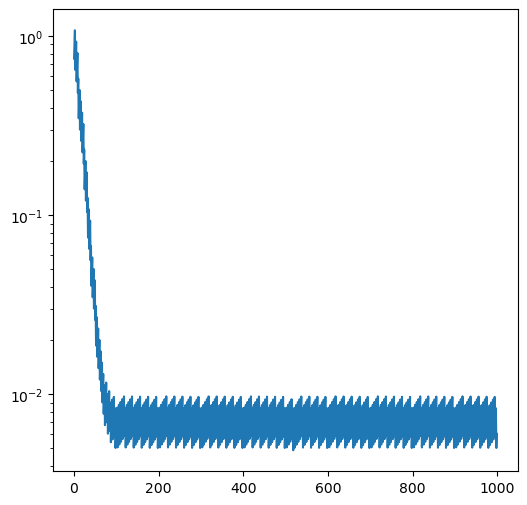

In [43]:
plt.semilogy(step_sizes_ep)

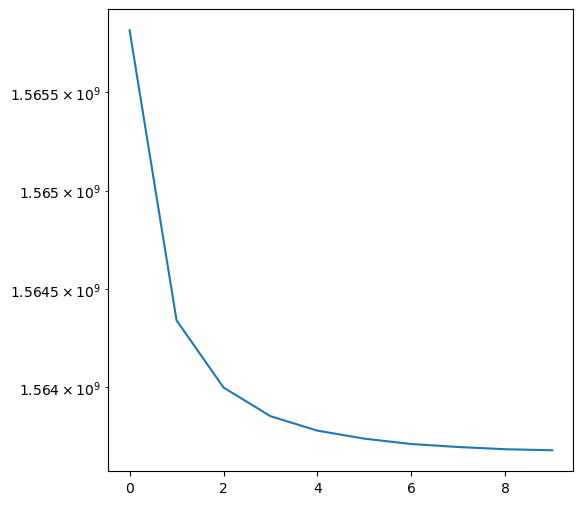

In [44]:
plt.semilogy(loss_ep)

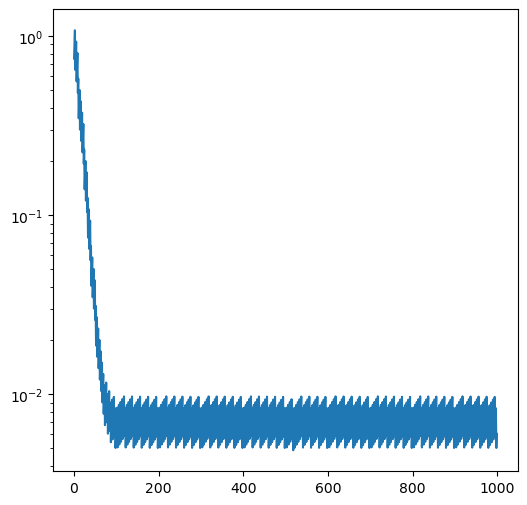

In [45]:
plt.semilogy(step_sizes_ep)

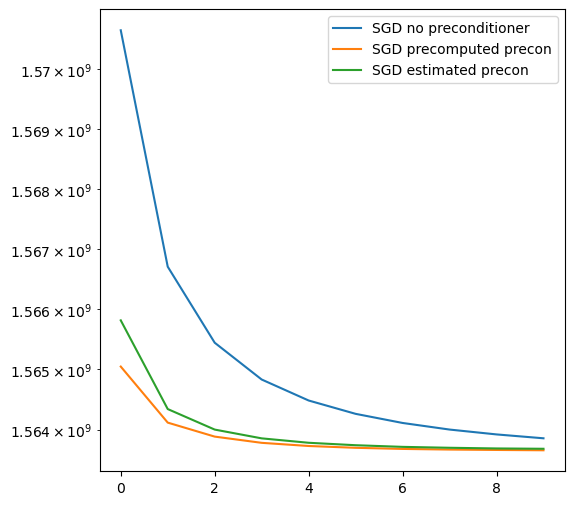

In [46]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.legend()

### 3b. SGD: estimated preconditioner, no thresholding

In [47]:
t0 = time.time()

alpha_nothresh = 1e-14

v_ep_nothresh, loss_ep_nothresh, iterates_ep_nothresh, step_sizes_ep_nothresh = precon_sgd(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha_nothresh,
    N_epochs,
    batch_size=batch_size,
    N=N,
    adaptive_step_size=True,
    c=c,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10


100%|█| 100/100 [00:50<00:00,  1.97it/s, eta=6.026e-03, loss=1.565e+09


  Loss =  1.56581496e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 2/10


100%|█| 100/100 [00:42<00:00,  2.36it/s, eta=6.026e-03, loss=1.564e+09


  Loss =  1.56434044e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 3/10


100%|█| 100/100 [00:42<00:00,  2.35it/s, eta=6.026e-03, loss=1.559e+09


  Loss =  1.56399948e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 4/10


100%|█| 100/100 [00:42<00:00,  2.35it/s, eta=6.026e-03, loss=1.563e+09


  Loss =  1.56385367e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 5/10


100%|█| 100/100 [00:42<00:00,  2.36it/s, eta=6.026e-03, loss=1.562e+09


  Loss =  1.56378037e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 6/10


100%|█| 100/100 [00:42<00:00,  2.36it/s, eta=6.026e-03, loss=1.559e+09


  Loss =  1.56373968e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 7/10


100%|█| 100/100 [00:42<00:00,  2.35it/s, eta=6.026e-03, loss=1.561e+09


  Loss =  1.56371240e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 8/10


100%|█| 100/100 [00:42<00:00,  2.35it/s, eta=6.026e-03, loss=1.564e+09


  Loss =  1.56369728e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 9/10


100%|█| 100/100 [00:42<00:00,  2.35it/s, eta=6.026e-03, loss=1.561e+09


  Loss =  1.56368604e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Epoch 10/10


100%|█| 100/100 [00:42<00:00,  2.37it/s, eta=6.026e-03, loss=1.565e+09


  Loss =  1.56368071e+09
  eta = 0.00602580072314699
  alpha= 1e-14
Total time:  490.99 seconds


In [48]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_ep_nothresh.npy", iterates_ep_nothresh)
    jnp.save(f"{iterates_file_root}/iterates_ep_nothresh_loss.npy", loss_ep_nothresh)
    jnp.save(f"{iterates_file_root}/step_sizes_ep_nothresh.npy", step_sizes_ep_nothresh)

In [70]:
load_iterates = True

if load_iterates:
    iterates_ep_nothresh = np.load(f"{iterates_file_root}/iterates_ep_nothresh.npy")
    loss_ep_nothresh = jnp.load(f"{iterates_file_root}/iterates_ep_nothresh_loss.npy")
    step_sizes_ep_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_ep_nothresh.npy")

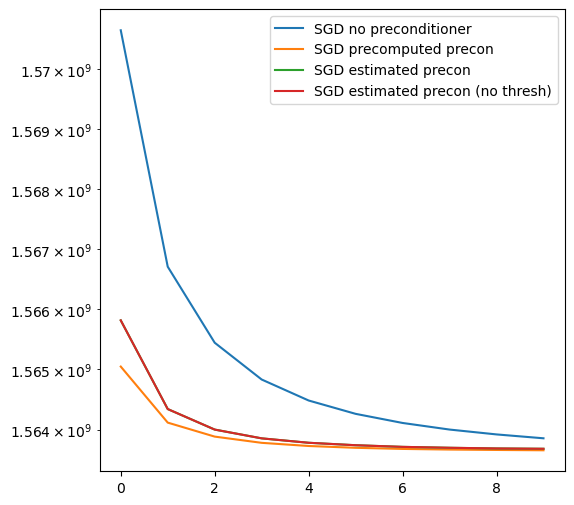

In [50]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.legend()

### OASIS as in described in Jahani et al

In [51]:
t0 = time.time()

v_oa, loss_oa = oasis_adaptive(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha,
    N_epochs,
    batch_size=batch_size,
    N=N,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10


100%|███████████████| 100/100 [00:45<00:00,  2.19it/s, loss=1.454e+09]


  Loss =  1.620e+09
Epoch 2/10


100%|███████████████| 100/100 [00:45<00:00,  2.21it/s, loss=1.450e+09]


  Loss =  1.621e+09
Epoch 3/10


100%|███████████████| 100/100 [00:45<00:00,  2.22it/s, loss=1.451e+09]


  Loss =  1.621e+09
Epoch 4/10


100%|███████████████| 100/100 [00:45<00:00,  2.22it/s, loss=1.453e+09]


  Loss =  1.621e+09
Epoch 5/10


100%|███████████████| 100/100 [00:45<00:00,  2.22it/s, loss=1.453e+09]


  Loss =  1.622e+09
Epoch 6/10


100%|███████████████| 100/100 [00:45<00:00,  2.22it/s, loss=1.452e+09]


  Loss =  1.621e+09
Epoch 7/10


100%|███████████████| 100/100 [00:44<00:00,  2.22it/s, loss=1.452e+09]


  Loss =  1.621e+09
Epoch 8/10


100%|███████████████| 100/100 [00:44<00:00,  2.22it/s, loss=1.453e+09]


  Loss =  1.622e+09
Epoch 9/10


100%|███████████████| 100/100 [00:44<00:00,  2.22it/s, loss=1.454e+09]


  Loss =  1.621e+09
Epoch 10/10


100%|███████████████| 100/100 [00:44<00:00,  2.22it/s, loss=1.452e+09]


  Loss =  1.621e+09
Total time:  517.81 seconds


Text(0.5, 1.0, 'Loss')

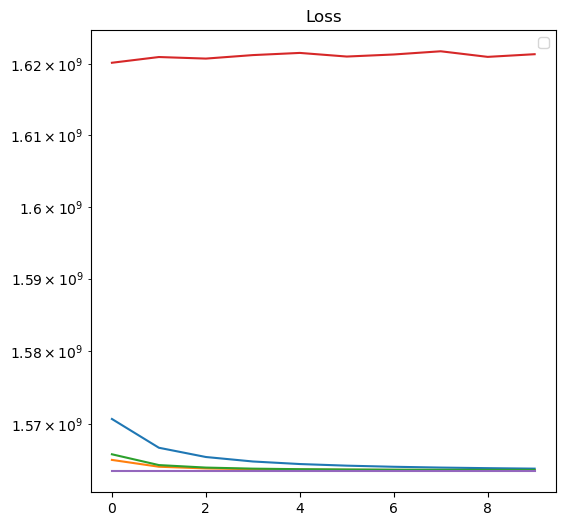

In [53]:
plt.legend()

plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_oa, label='OASIS')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.title("Loss")

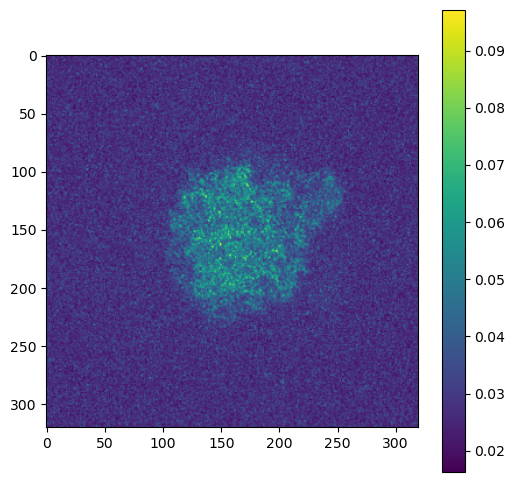

In [54]:
v_oal, _ = rescale_larger_grid(v_oa, x_grid, nx0)
vr_oa = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_oal)))

mip_z(vr_oa)
plt.colorbar()

### L-BFGS

In [238]:
batch_size_lbfgs = 500
N_batch = N / batch_size_lbfgs
idx_batches = np.array_split(np.arange(N), N_batch)

# We don't jit the overall loss functions here because
# compiling the unrolled iterations over all batches will
# take a long time.
# The individual loss_func and grad_func are jit-ed.
def loss_and_grad_full_func_lbfgs(x):
    t0 = time.time()
    print("loss_and_grad_full_func_lbfgs called ", end="")
    loss = 0
    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        grad += grad_func(x, idx)
        n += 1

    loss = loss / n
    grad = grad / n

    # loss_full = jnp.mean(jnp.array(loss_b), axis = 0)
    # grad_full = jnp.mean(jnp.array(grad_b), axis = 0)

    tt = time.time() - t0
    print(f"{tt} seconds")
    return loss, jnp.conj(grad)

def loss_full_func_lbfgs(x):
    t0 = time.time()
    print("loss_full_func_lbfgs called ", end="")
    loss = 0
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        n += 1

    loss = loss / n
    
    tt = time.time() - t0
    print(f"{tt} seconds")
    return loss

In [48]:
t0 = time.time()
r1, r2 = loss_and_grad_full_func_lbfgs(x0)
r1 = loss_full_func_lbfgs(x0)

t1 = time.time() - t0

print(t1)

loss_and_grad_full_func_lbfgs called 20.502240896224976 seconds
loss_full_func_lbfgs called 5.7951109409332275 seconds
26.298248291015625


In [228]:
# [x.delete() for x in jax.devices()[0].client.live_buffers()]

In [51]:
# Both zoom (default) and backtracking line searches hang, so we'll use neither with a learning rate of 0.5.
solver = optax.lbfgs(learning_rate=0.5, linesearch=None)
opt_state = solver.init(x0)

In [62]:
N_iters = 750
losses_lbfgs = []

In [ ]:
v_lbfgs = x0
for i in range(N_iters):
    print(f'Iter {i}')
    value, grad = loss_and_grad_full_func_lbfgs(v_lbfgs)
    losses_lbfgs.append(value)
    updates, opt_state = solver.update(
        grad, opt_state, v_lbfgs, value=value, grad=grad, value_fn=loss_full_func_lbfgs
    )
    v_lbfgs = optax.apply_updates(v_lbfgs, updates)
    print('Objective function: ', value)
losses_lbfgs = jnp.array(losses_lbfgs)

Iter 0
loss_and_grad_full_func_lbfgs called 

1563494735.8733027


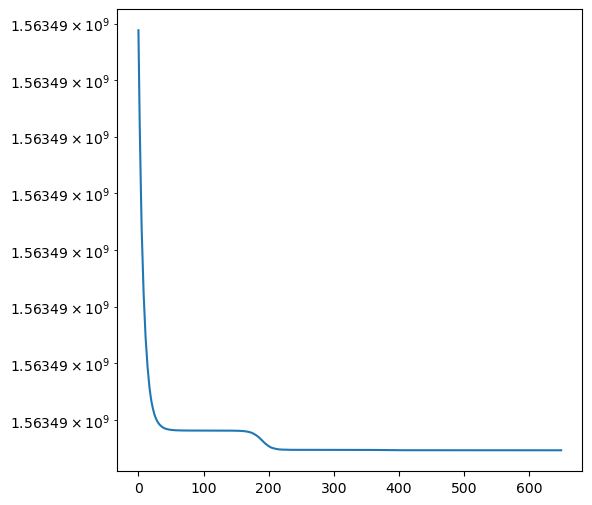

In [86]:
plt.semilogy(losses_lbfgs)
print(losses_lbfgs[-1])

In [66]:
loss_lbfgs = loss_full_func_lbfgs(v_lbfgs)
print(loss_lbfgs)

loss_full_func_lbfgs called 4.082464218139648 seconds
1563494735.8733041


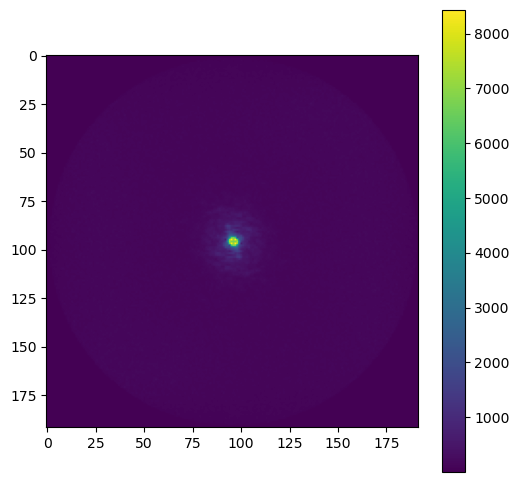

In [67]:
mip_x(np.fft.fftshift(np.abs(v_lbfgs)))
plt.colorbar()

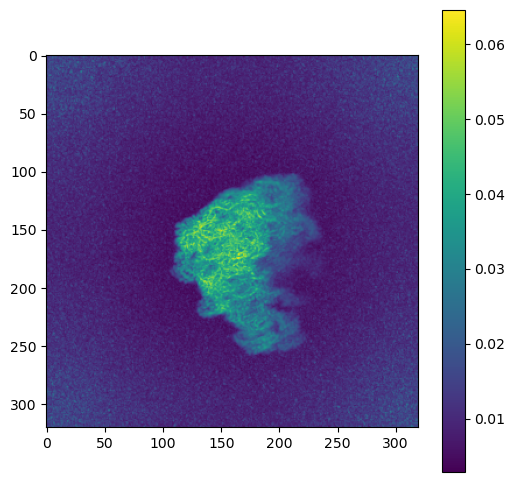

In [68]:
v_lbfgs_l, _ = rescale_larger_grid(v_lbfgs, x_grid, nx0)
vr_lbfgs = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs_l)))

mip_x(vr_lbfgs)
plt.colorbar()

In [69]:
nnstring = ""


In [70]:
# Save two: at the original nx0 (=320) and at the actual computed nx so no accuracy is lost
with mrcfile.new(
    f"{out_dir}/v_rec_lbfgs_{nnstring}{N_iters}_nx0.mrc", overwrite=True
) as mrc:
    mrc.set_data(vr_lbfgs.astype(np.float32))

vr_lbfgs_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs)))
# vr_lbfgs_nx = jnp.fft.ifftn(v_lbfgs)

with mrcfile.new(f"{out_dir}/v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_lbfgs_nx.astype(np.float32))

In [71]:
v_lbfgs_nx = jnp.fft.fftn(jnp.fft.ifftshift(vr_lbfgs_nx))

In [20]:
# Load
# nnstring = "nn_"
nnstring = ""
N_iters = 750

with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
    vr_lbfgs_loaded = mrc.data

v_lbfgs_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs_loaded)))

vr_lbfgs = vr_lbfgs_loaded
v_lbfgs = v_lbfgs_loaded

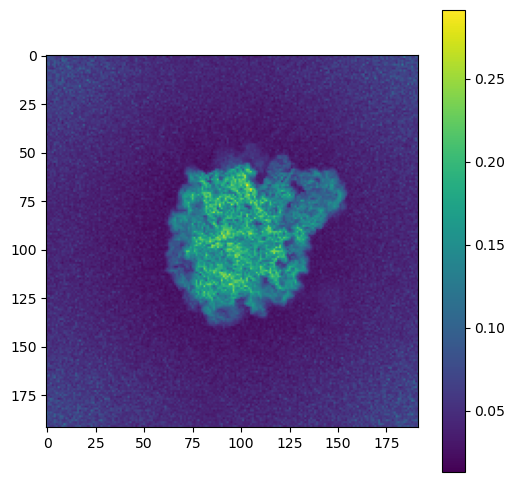

In [21]:
mip_z(vr_lbfgs_loaded)
plt.colorbar()

In [22]:
vrerr = jnp.abs(v_lbfgs - v_lbfgs_loaded)
print(jnp.max(vrerr) / jnp.max(jnp.abs(v_lbfgs)))
print(jnp.mean(vrerr) / jnp.max(jnp.abs(v_lbfgs)))

0.0
0.0


In [25]:
loss_lbfgs = loss_full_func(v_lbfgs, jnp.arange(N))
loss_lbfgs_2 = loss_full_func_lbfgs(v_lbfgs)

# loss_bfgs_loaded = loss_full_func(v_lbfgs_loaded, jnp.arange(N))

print(loss_lbfgs)
print(loss_lbfgs_2)
# print(loss_lbfgs_loaded)

loss_full_func_lbfgs called 7.928206205368042 seconds
1563494762.5268562
1563494762.5268564


Text(0.5, 1.0, 'Loss')

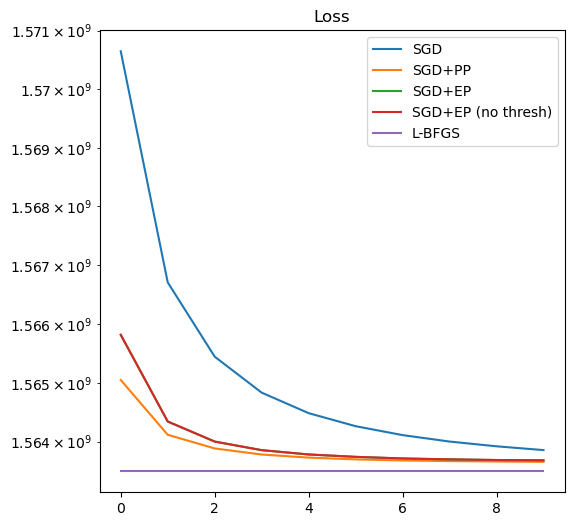

In [71]:
plt.semilogy(loss_np, label='SGD')
plt.semilogy(loss_pp, label='SGD+PP')
plt.semilogy(loss_ep, label='SGD+EP')
plt.semilogy(loss_ep_nothresh, label='SGD+EP (no thresh)')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.legend()
plt.title("Loss")

## Diagnostics


#### First: the loss and the step size

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)

plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.legend()
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_np, label='SGD no preconditioner')
plt.semilogy(step_sizes_pp, label='SGD precomputed precon')
plt.semilogy(step_sizes_ep, label='SGD estimated precon')
plt.semilogy(step_sizes_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.title("Step size")

plt.rcParams["figure.figsize"] = 6, 6

### Error and FSC (with the L-BFGS solution) in shells

In [174]:
def err_px(v1, v2):
    err = 1 / 2 * jnp.real(jnp.conj(v1 - v2) * (v1 - v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)
    
    return jnp.array([avg_err, max_err, median_err])

err_px_iterates = jax.vmap(lambda vv: err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(
    lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1
)

In [94]:
averr_np, maxerr_np, mederr_np = err_px_iterates(jnp.array(iterates_np))
averr_pp, maxerr_pp, mederr_pp = err_px_iterates(jnp.array(iterates_pp))
averr_pp_nothresh, maxerr_pp_nothresh, mederr_pp_nothresh = err_px_iterates(jnp.array(iterates_pp_nothresh))
averr_ep, maxerr_ep, mederr_ep = err_px_iterates(jnp.array(iterates_ep))
averr_ep_nothresh, maxerr_ep_nothresh, mederr_ep_nothresh = err_px_iterates(jnp.array(iterates_ep_nothresh))

print(averr_np.shape)
print(maxerr_np.shape)
print(mederr_np.shape)

(11, 55)
(11, 55)
(11, 55)


In [125]:
res, fsc_np, shell_pts = fsc_iterates(jnp.array(iterates_np))
res, fsc_pp, shell_pts = fsc_iterates(jnp.array(iterates_pp))
res, fsc_pp_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_pp_nothresh))
res, fsc_ep, shell_pts = fsc_iterates(jnp.array(iterates_ep))
res, fsc_ep_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_ep_nothresh))

print(fsc_np.shape)
print(fsc_pp.shape)
print(fsc_ep.shape)

(11, 55)
(11, 55)
(11, 55)


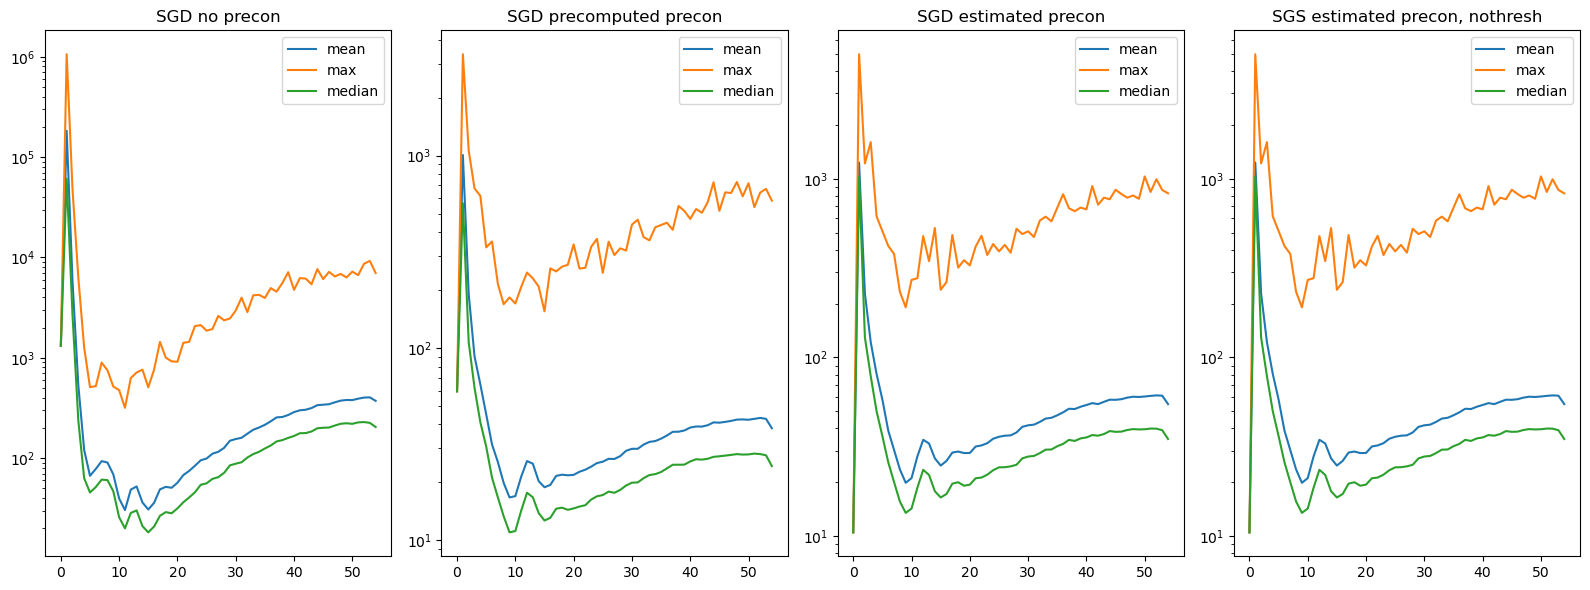

In [126]:
idx = 10

plt.figure(figsize=(16,6))
#plt.title(f'Shell {idx+1}/{averr_np.shape[-1]}\n')

#ylims = [10,10**6.6]

plt.subplot(141)
plt.semilogy((averr_np[idx]))
plt.semilogy((maxerr_np[idx]))
plt.semilogy((mederr_np[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD no precon")
#plt.ylim(ylims)

plt.subplot(142)
plt.semilogy((averr_pp[idx]))
plt.semilogy((maxerr_pp[idx]))
plt.semilogy((mederr_pp[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD precomputed precon")
#plt.ylim(ylims)

plt.subplot(143)
plt.semilogy((averr_ep[idx]))
plt.semilogy((maxerr_ep[idx]))
plt.semilogy((mederr_ep[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD estimated precon")
plt.tight_layout()
#plt.ylim(ylims)

plt.subplot(144)
plt.semilogy((averr_ep_nothresh[idx]))
plt.semilogy((maxerr_ep_nothresh[idx]))
plt.semilogy((mederr_ep_nothresh[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGS estimated precon, nothresh")
#plt.ylim(ylims)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Error accross epochs at frequency shell 55/55')

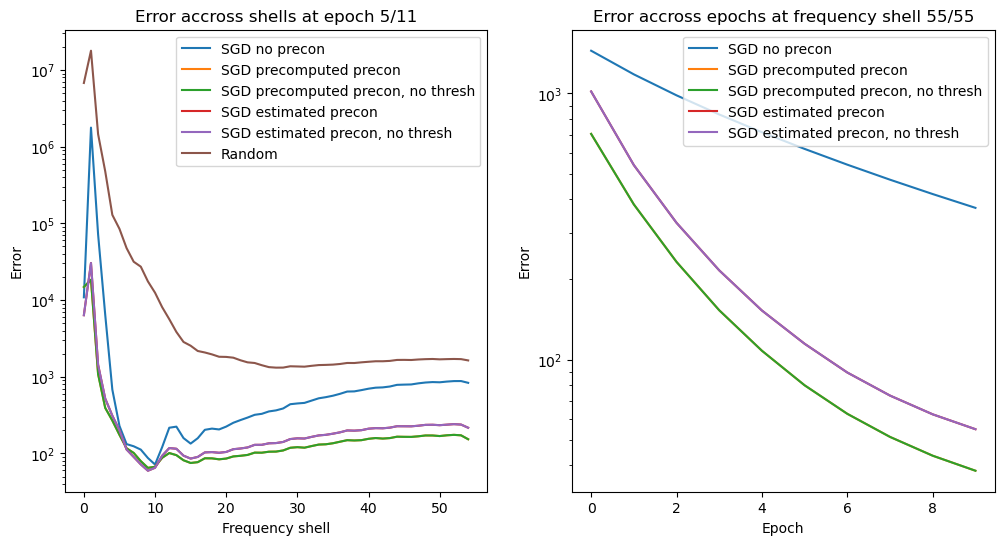

In [131]:
idx = 4

plt.figure(figsize=(12, 6))
#plt.title(f'Shell {idx}/{averr_np.shape[-1]}\n')

plt.subplot(121)

plt.semilogy(averr_np[idx])
plt.semilogy(averr_pp[idx])
plt.semilogy(averr_pp_nothresh[idx])
plt.semilogy(averr_ep[idx])
plt.semilogy(averr_ep_nothresh[idx])
plt.semilogy(averr_np[0])

plt.legend(
    [
        'SGD no precon',
        'SGD precomputed precon',
        'SGD precomputed precon, no thresh',
        'SGD estimated precon',
        'SGD estimated precon, no thresh',
        "Random",
    ]
)
plt.xlabel("Frequency shell")
plt.ylabel("Error")
plt.title(f"Error accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 54
plt.semilogy(averr_np[1:, idx_shell])
plt.semilogy(averr_pp[1:, idx_shell])
plt.semilogy(averr_pp_nothresh[1:, idx_shell])
plt.semilogy(averr_ep[1:, idx_shell])
plt.semilogy(averr_ep_nothresh[1:, idx_shell])

plt.legend(
    [
        'SGD no precon',
        'SGD precomputed precon',
        'SGD precomputed precon, no thresh',
        'SGD estimated precon',
        'SGD estimated precon, no thresh',
    ]
)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title(f"Error accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

#### The resolution in Angs
If ``res``, the radius in the Fourier domain, goes from 0 to R, where $R \approx \frac{Npixels}{2}$, 
then ``res_angs(res)``$=\frac{N0 pixels \times px0}{res}$,
where ``N0pixels``= number of pixels in the original images (here 320) 
and ``px0`` = pixel size (here 1.33 Angs), 
so ``res_angs`` goes from ``N0pixels x px0`` to ``N0pixels x px0 x 2 / Npixels``

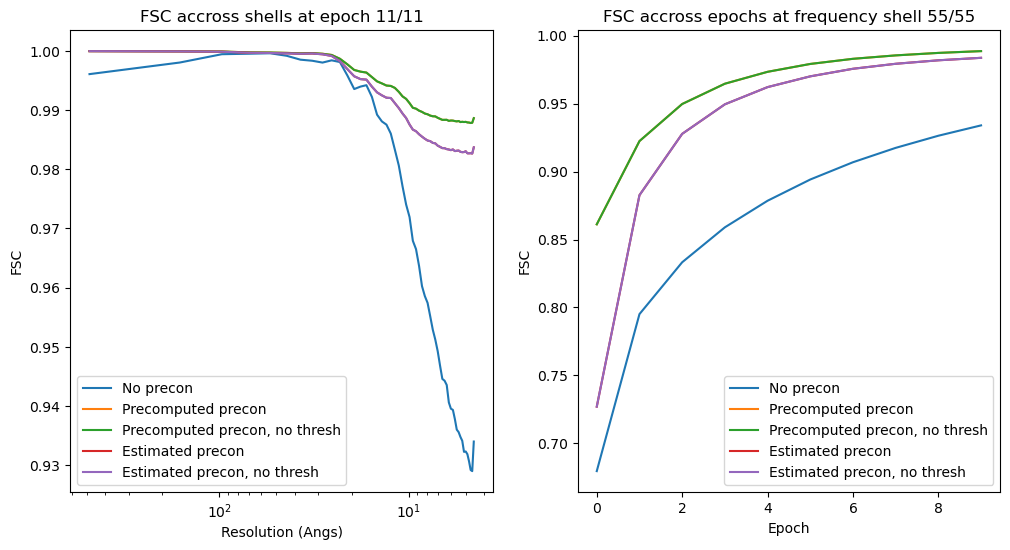

In [140]:
res_angs = nx0 * pixel_size[0] / res[0]

plt.figure(figsize=(12, 6))

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_np[idx, 1:])
plt.semilogx(res_angs[1:], fsc_pp[idx, 1:])
plt.semilogx(res_angs[1:], fsc_pp_nothresh[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep_nothresh[idx, 1:])

plt.gca().invert_xaxis()
plt.legend(
    [
        'No precon',
        'Precomputed precon',
        'Precomputed precon, no thresh',
        'Estimated precon',
        'Estimated precon, no thresh',
    ]
)
plt.xlabel("Resolution (Angs)")
plt.ylabel("FSC")
plt.title(f"FSC accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 54
plt.plot(fsc_np[1:, idx_shell])
plt.plot(fsc_pp[1:, idx_shell])
plt.plot(fsc_pp_nothresh[1:, idx_shell])
plt.plot(fsc_ep[1:, idx_shell])
plt.plot(fsc_ep_nothresh[1:, idx_shell])

plt.legend(
    [
        'No precon',
        'Precomputed precon',
        'Precomputed precon, no thresh',
        'Estimated precon',
        'Estimated precon, no thresh',
    ]
)
plt.xlabel("Epoch")
plt.ylabel("FSC")
plt.title(f"FSC accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

plt.rcParams["figure.figsize"] = 6, 6

### FSC heatmap for Fourier shell vs epoch

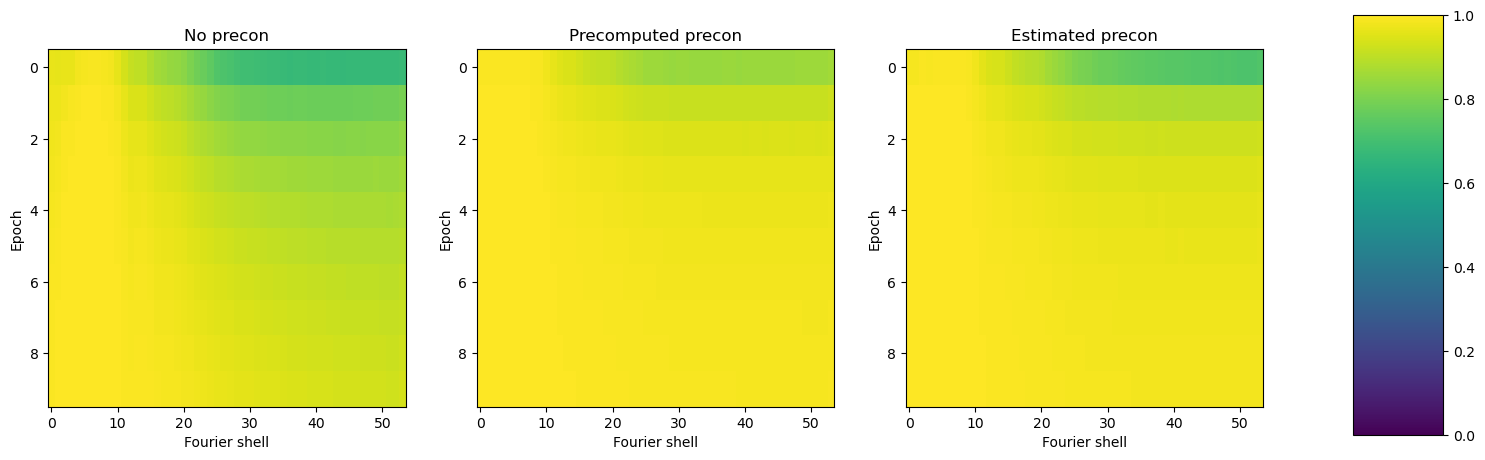

In [142]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)


plt.rcParams["figure.figsize"] = 18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_np[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("No precon")

ax = fig.add_subplot(132)
ax.imshow(fsc_pp[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("Precomputed precon")

ax = fig.add_subplot(133)
im = ax.imshow(fsc_ep[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("Estimated precon")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

#### Also look at the preconditioner

In [143]:
_, precon_radial_mean, _, precon_radial_max, precon_radial_median = average_shells(
    (1 / D0hat), x_grid
)
_, D0_radial_mean, _, D0_radial_max, D0_radial_median = average_shells(D0hat, x_grid)

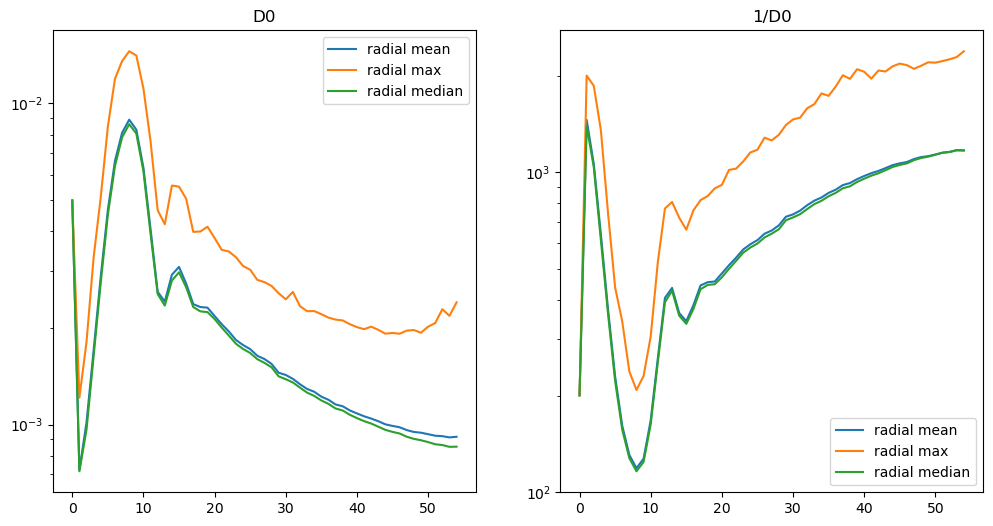

In [144]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("D0")

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("1/D0")

plt.rcParams["figure.figsize"] = 6, 6

### The variance of the gradients

In [240]:
key = random.PRNGKey(45)
vol = iterates_np[5]

In [241]:
def compute_grad_variance(key, v, batch_size, P=None):
    idxs_rand = random.permutation(key, jnp.arange(N))
    N_batch = int(N / batch_size)

    if P is None:
        P = jnp.ones(v.shape)

    # Doing this on GPU with JAX takes _extremely_ long to compile.
    # DO NOT ATTEMPT !!!
    idx_batches = np.array(np.array_split(np.array(idxs_rand), N_batch))

    grads = []
    for idx in tqdm(idx_batches):
        grads.append(grad_full_func(v, idx))

    grads = P * np.array(grads)

    mean_grad = np.mean(grads, axis=0)
    var_grad = np.var(grads, axis=0)

    return mean_grad, var_grad

In [242]:
# grad_full = grad_full_func(vol, jnp.arange(N))
_, grad_full = loss_and_grad_full_func_lbfgs(vol)

loss_and_grad_full_func_lbfgs called 24.376089096069336 seconds


In [243]:
mean_grad_1000, var_grad_1000 = compute_grad_variance(key, vol, 1000)

100%|█████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


In [244]:
jnp.save(f"{out_dir}/grad_full.npy", grad_full)
jnp.save(f"{out_dir}/var_grad_1000.npy", var_grad_1000)

In [245]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid)  # The median computation doesn't like complex numbers
_, av_var_grad_1000, _, _, _ = average_shells(var_grad_1000, x_grid)

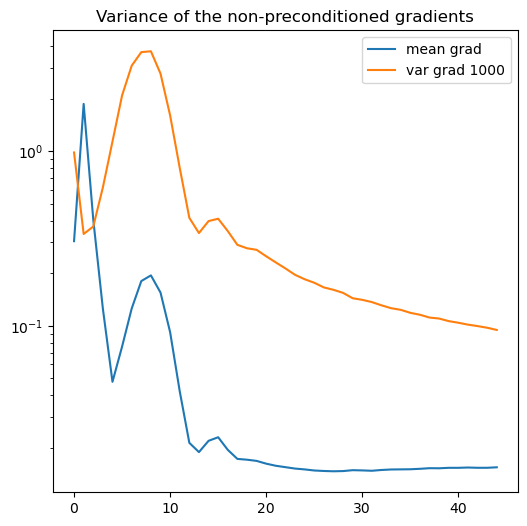

In [246]:
plt.semilogy(jnp.abs(avgrad_full[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000[:45]))

plt.title("Variance of the non-preconditioned gradients")
plt.legend(["mean grad", "var grad 1000"])

#### Without thresholding

In [247]:
grad_full_p_d0 = 1 / D0 * grad_full
mean_grad_1000_p_d0, var_grad_1000_p_d0 = compute_grad_variance(key, vol, 1000, 1 / D0)

100%|█████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


In [248]:
# assert jnp.max(jnp.abs(mean_grad_1000_p_d0 - grad_full_p_d0)) < 1e-10

In [249]:
jnp.save(f"{out_dir}/grad_full_p_d0.npy", grad_full_p_d0)
jnp.save(f"{out_dir}/var_grad_1000_p_d0.npy", var_grad_1000_p_d0)

In [250]:
_, avgrad_full_p_d0, _, _, _ = average_shells(
    jnp.abs(grad_full_p_d0), x_grid
)  # The median computation doesn't like complex numbers
_, av_var_grad_1000_p_d0, _, _, _ = average_shells(var_grad_1000_p_d0, x_grid)

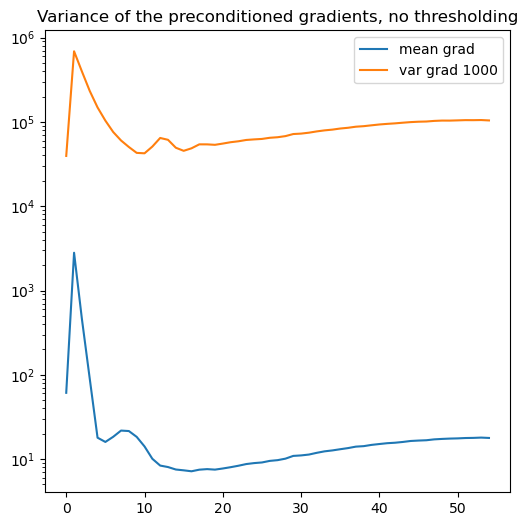

In [251]:
plt.semilogy(jnp.abs(avgrad_full_p_d0[:]))
plt.semilogy(jnp.abs(av_var_grad_1000_p_d0[:]))

plt.title("Variance of the preconditioned gradients, no thresholding")
plt.legend(["mean grad", "var grad 1000"])

#### With thresholding

In [252]:
grad_full_p = 1 / D0hat * grad_full

mean_grad_1000_p, var_grad_1000_p = compute_grad_variance(key, vol, 1000, 1 / D0hat)

100%|█████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


In [253]:
# Sanity checks
# assert jnp.max(jnp.abs(mean_grad_1000_p - grad_full_p)) < 1e-11

In [254]:
jnp.max(jnp.abs(mean_grad_1000_p - grad_full_p))

Array(5224.43491605, dtype=float64)

In [255]:
jnp.save(f"{out_dir}/grad_full_p_dhat.npy", grad_full_p)
jnp.save(f"{out_dir}/var_grad_1000_p_dhat.npy", var_grad_1000_p)

In [256]:
_, avgrad_full_p, _, _, _ = average_shells(
    jnp.abs(grad_full_p), x_grid
)  # The median computation doesn't like complex numbers
_, av_var_grad_1000_p, _, _, _ = average_shells(var_grad_1000_p, x_grid)

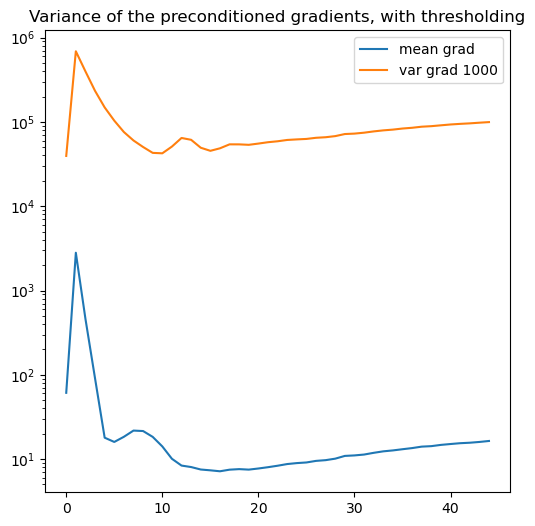

In [257]:
plt.semilogy(jnp.abs(avgrad_full_p[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000_p[:45]))

plt.title("Variance of the preconditioned gradients, with thresholding")
plt.legend(["mean grad", "var grad 1000"])